# Exploration de séquences vidéos d'oiseaux

In [ ]:
pip install av

   ---------------------------------------- 0.0/25.8 MB ? eta -:--:--
   ---------------------------------------- 0.0/25.8 MB ? eta -:--:--
   ---------------------------------------- 0.0/25.8 MB 320.0 kB/s eta 0:01:21
   ---------------------------------------- 0.1/25.8 MB 544.7 kB/s eta 0:00:48
   ---------------------------------------- 0.1/25.8 MB 819.2 kB/s eta 0:00:32
   ---------------------------------------- 0.2/25.8 MB 871.5 kB/s eta 0:00:30
   ---------------------------------------- 0.3/25.8 MB 1.2 MB/s eta 0:00:22
    --------------------------------------- 0.4/25.8 MB 1.3 MB/s eta 0:00:20
    --------------------------------------- 0.5/25.8 MB 1.6 MB/s eta 0:00:16
   - -------------------------------------- 0.7/25.8 MB 1.7 MB/s eta 0:00:15
   - -------------------------------------- 0.7/25.8 MB 1.8 MB/s eta 0:00:15
   - -------------------------------------- 0.7/25.8 MB 1.8 MB/s eta 0:00:15
   - -------------------------------------- 0.8/25.8 MB 1.5 MB/s eta 0:00:18
   - 

In [ ]:
import av
import os
import numpy as np
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt

### Step 1 - Get dataset paths

The dataset consists in two folders :
- **images** : with individual images grouped by sequences with name of type 'sequence=X_{videofilename}_frame=XXXX.jpg'
- **labels** : associated labels in files of type  'sequence=X_{videofilename}_frame=XXXX.txt'

In [ ]:
path = "./PROCESSED"
imgs_path = os.listdir(f"{path}/images/")   # list of annotated images
labels_path = os.listdir(f"{path}/images/") # list of associates annotations

In [ ]:
if (len(imgs_path) == len(labels_path)):
    print("Total number of annotated images :", len(imgs_path))
else :
    print(f"There is a mismatch between images quantity (n={len(imgs_path)}) and annotations quantity (n={len(labels_path)})")

Total number of annotated images : 41210


### Step 2 - Draw annotation  on image

Each image is associated to a label.

Here we want draw an image with its associated labels (rectangular boxes).
The rectangular boxes are supposed to indicate the presence of a seabird

Please check what are [YOLO](https://medium.com/@rajdeepsingh/a-quick-reference-for-bounding-boxes-in-object-detection-f02119ddb76b) and [PASCAL VOC](https://medium.com/@rajdeepsingh/a-quick-reference-for-bounding-boxes-in-object-detection-f02119ddb76b) bounding box reference formats

In [ ]:
# define function to read & format annotations
def read_annotation(path):
    """
    Reads annotation file

    Parameters:
    path (str): Path to the txt file

    Returns:
    List: List of Bounding boxes in YOLO format [object_id center_x, center_y, width, height]
    """
    with open(path) as f:
        boxes = f.read().splitlines()
        boxes = [l.split(' ') for l in boxes]
        boxes = [[float(v) for v in box] for box in boxes]
    return boxes

def bbox_format(bbox, total_width=2560, total_height=1920):
    """
    Convert Bounding Boxes Format

    Parameters:
    bbox (List): List of Bounding boxes in YOLO format [object_id center_x, center_y, width, height]

    Returns:
    List: List of Bounding boxes in PASCAL VOC [xmin, ymin, xmax, ymax]
    """

    center_x, center_y, width, height = bbox[1], bbox[2], bbox[3], bbox[4]

    xmin = (center_x - width/2)*total_width
    ymin = (center_y - height/2)*total_height
    xmax = (center_x + width/2)*total_width
    ymax = (center_y + height/2)*total_height

    return [xmin, ymin, xmax, ymax]

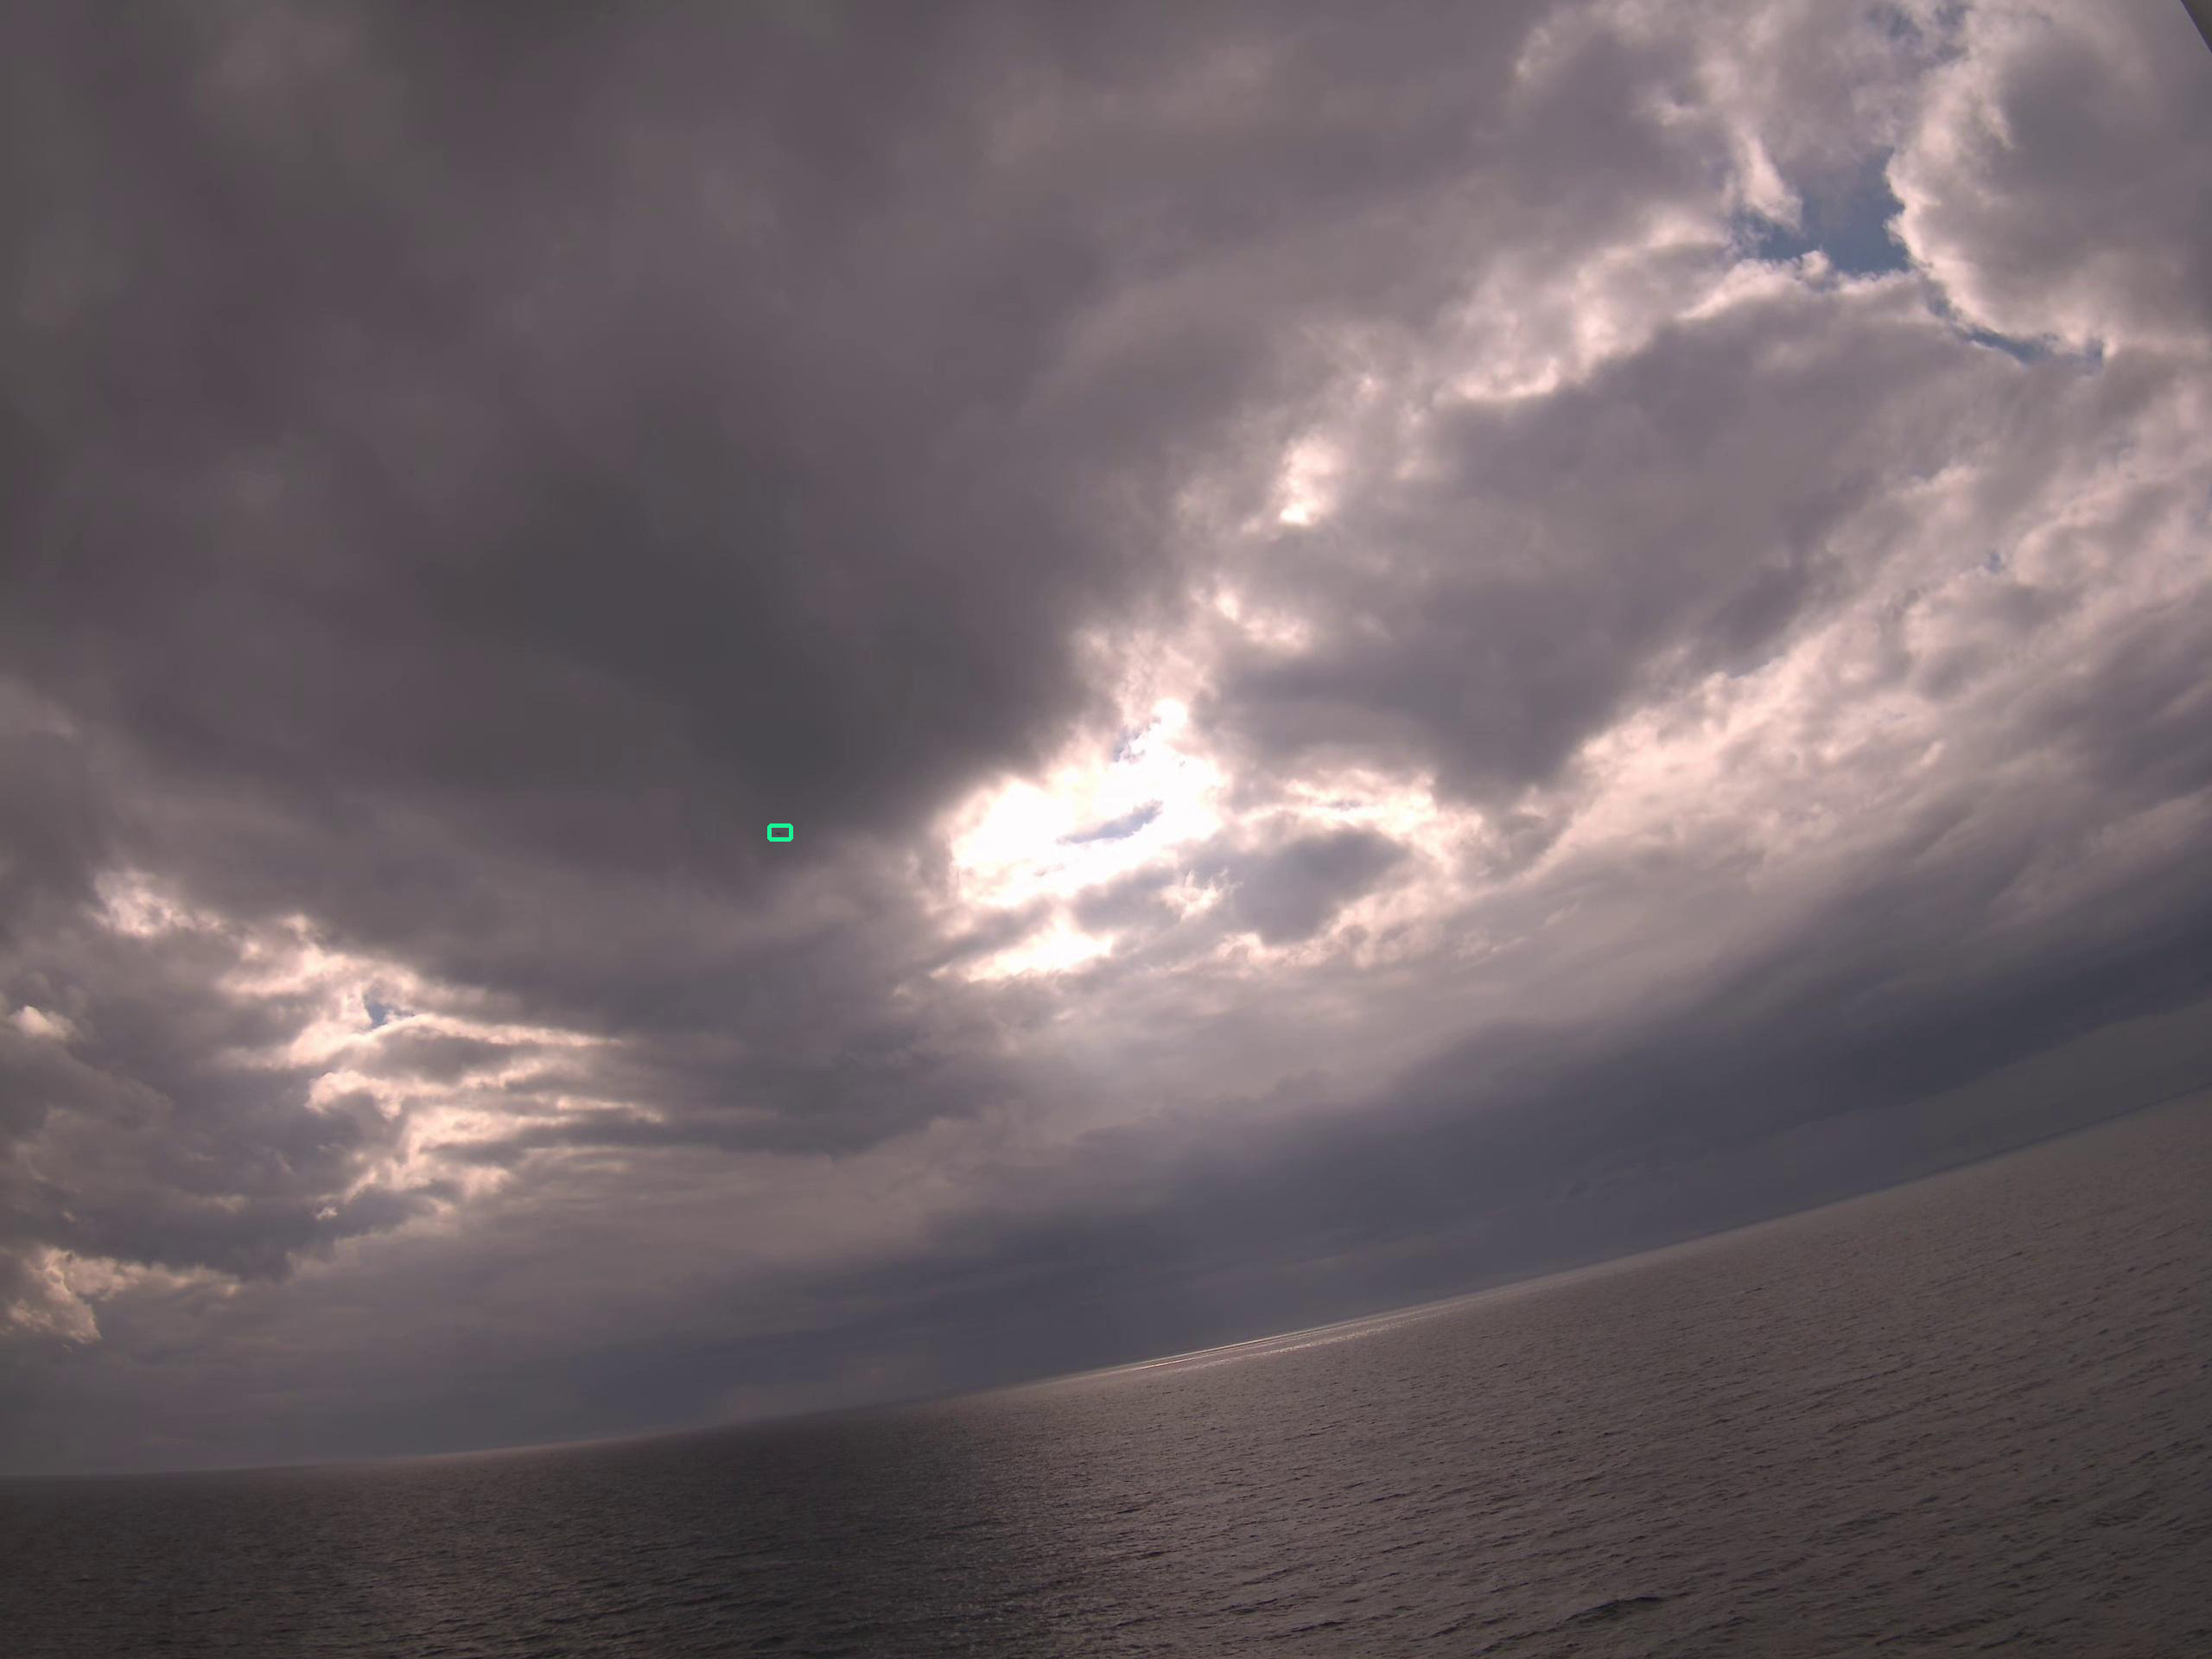

In [ ]:
ii = 2000 # select random frame
img_path = os.path.join(f"{path}/images/", imgs_path[ii])
label_path = os.path.join(f"{path}/labels/", labels_path[ii])


# Open img
img = Image.open(img_path).convert("RGB")

# Add bounding boxes to images
draw = ImageDraw.Draw(img, 'RGBA')
bboxes = read_annotation(label_path)
color = (25, 245, 150, 255)
for box in bboxes:
    box = bbox_format(box)
    x, y, width, height = box[0], box[1], box[2]-box[0], box[3]-box[1]
    draw.rounded_rectangle([x, y, x + width, y + height], radius=5, width = 5, outline=color)

# Plot Image
img

### Step 3 : Select Video Sequence

Now we want to select a video sequence from annotated images, so we need to subset the images/labels based on their name

For example the **sequence=1** is described by all images/labels that starts with name 'sequence=1...'

In [ ]:
n_seq = 1

# subset paths for a given sequence
seq_imgs_path =[p for p in imgs_path if p.startswith(f'sequence={n_seq}_')]
seq_labels_path =[p for p in labels_path if p.startswith(f'sequence={n_seq}_')]

UnicodeDecodeError: 'charmap' codec can't decode byte 0x81 in position 251: character maps to <undefined>

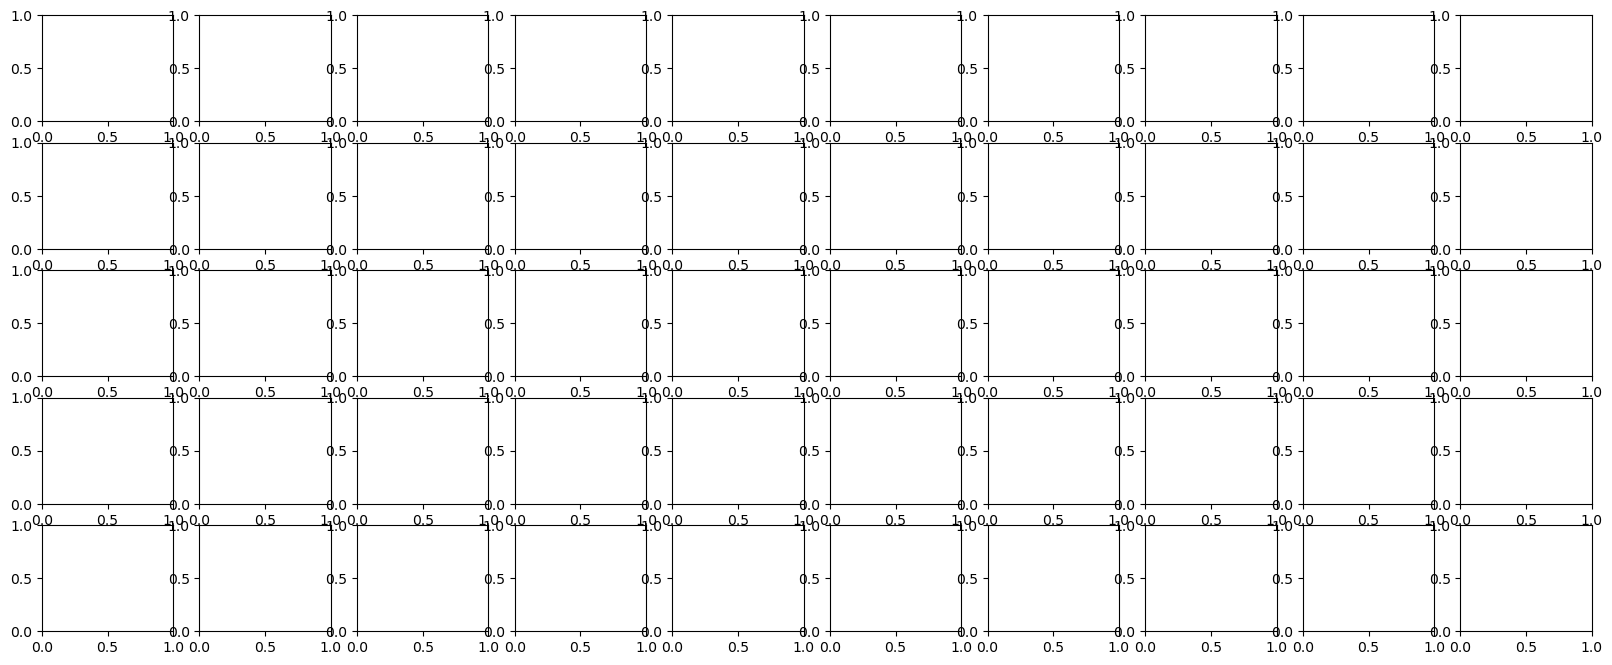

In [ ]:
# iterative plot of boxes for the first 50 frames of the sequence
fig, ax = plt.subplots(5, 10, figsize=(20, 8))
ax=ax.flatten()
for ii in range(50):
    img_path = os.path.join(f"{path}/images/", seq_imgs_path[ii])
    label_path = os.path.join(f"{path}/images/", seq_labels_path[ii])

    # Open img
    img = Image.open(img_path).convert("RGB")

    # Add bounding boxes to images
    draw = ImageDraw.Draw(img, 'RGBA')
    bboxes = read_annotation(label_path)
    color = (25, 245, 150, 255)
    for box in bboxes:
        box = bbox_format(box)
        x, y, width, height = box[0], box[1], box[2]-box[0], box[3]-box[1]
        draw.rounded_rectangle([x, y, x + width, y + height], radius=5, width = 10, outline=color, fill = color)

    # Plot Image
    ax[ii].imshow(img)
    ax[ii].axis('off')


### Step 4 : Read a raw video file

Now assume you want to retrieve an annotated image sequence from the raw video file  :

Example : Sequence 1 is from raw video file "video-20220511_132051-00.mkv"

In [ ]:
img_filename= seq_imgs_path[0]                              # get random image from given sequence
video_file = '_'.join(img_filename.split("_")[1:3]) + '.mkv' # get associated video file

frame_start = int(seq_imgs_path[0].split("_")[3][6:-4])  # get sequence start frame number
frame_end = int(seq_imgs_path[-1].split("_")[3][6:-4])   # get sequence end frame number

In [ ]:
video_file_dir = "path/to/video/directory"
video_file_path = os.path.join(video_file_dir, video_file)

## /!\ Looping through a whole video is time consuming
container = av.open(video_file_path)
list_frames = []
for i, frame in enumerate(container.decode(video=0)):
    id = i+1 # correct for 0-indexing
    if (id >= frame_start) & (id <= frame_end):
        list_frames.append({'id':id, 'frame':frame.to_image(), 'time':frame.pts})
    if id == frame_end:
        break
container.close()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


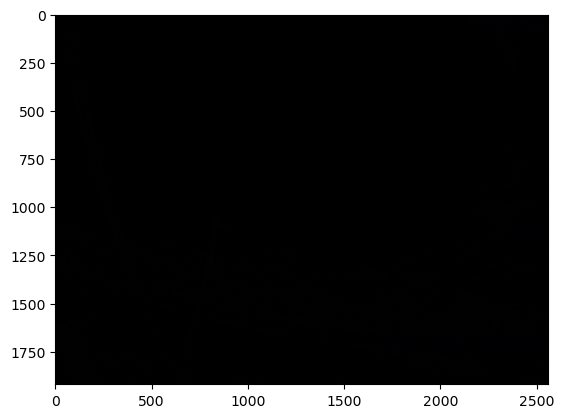

In [ ]:
# test match between images from raw video
img_filename= seq_imgs_path[0]
img_path = os.path.join(f"{path}/images/", img_filename)
img = Image.open(img_path).convert("RGB")

# Note image are not exactly the same due to image compression in .png
# But they describe the exact same scene
np.sum(np.array(img) != np.array(list_frames[0]['frame']))
plt.imshow(np.array(img).astype(int) - np.array(list_frames[0]['frame']).astype(int))